**Chapter 4 – Training Models**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/machinelearning/blob/main/040-training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

- So far we have treated Machine Learning models and their training algorithms mostly like black boxes.
- Having a good understanding of how things work can help you quickly home in on the appropriate model, the right training algorithm to use, and a good set of hyperparameters for your task.
- Most of the topics discussed in this chapter will be essential in understanding, building, and training neural networks


***Content***
1. Linear Regression
2. Polynomial Regression.
3. Regularized Linear Models
4. Logistic Regression.


# 0. Setup Python

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 1. Linear Regression

In Chapter 1 we looked at a simple regression model of life satisfaction:

$$
LifeSatisfaction = θ_0 + θ_1 × GDPPerCapita
$$

More generally: 

$$
\hat{y} = θ_0 + θ_1x_1 + θ_2x_2 +⋯+ θ_nx_n
$$

In this equation: 

- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the i<sup>th</sup> feature value.
- $\theta_j$ is the j<sup>th</sup> model parameter (including the bias term θ<sub>0</sub> and the feature weights θ<sub>1</sub>, θ<sub>2</sub>, ⋯, θ<sub>n</sub>).

This can be written much more concisely using a vectorized form as:

$$
\hat{y} = h_0(\mathbf{x})  = \mathbf{θ} \cdot \mathbf{x}
$$

In this equation:
- $\mathbf{θ}$ is the model’s parameter vector, containing the bias term _θ<sub>0</sub>_ and the feature weights _θ<sub>1</sub>_ to _θ<sub>n</sub>_.
- $\mathbf{x}$ is the instance’s feature vector, containing x<sub>0</sub> to x<sub>n</sub> , with x<sub>0</sub> always equal to 1.
- $\mathbf{θ} \cdot \mathbf{x}$ is the dot product of the vectors $\mathbf{θ}$ and $\mathbf{x}$, which is equal to $θ_0x_0 + θ_1x_1 + θ_2x_2 +⋯+ θ_nx_n$.
- $h$ is the hypothesis function, using the model parameters $\mathbf{θ}$.

In Machine Learning, vectors are often represented as column vectors, which are 2D
arrays with a single column. If $\mathbf{θ}$ and $\mathbf{x}$ are column vectors, then the prediction is
$\hat{y} = \mathbf{θ}^T\mathbf{x}$, where $\mathbf{θ}^T$ is the transpose of $\mathbf{θ}$ (a row vector instead of a column vector) and
$\mathbf{θ}^T\mathbf{x}$ is the matrix multiplication of $\mathbf{θ}^T$ and $\mathbf{x}$. It is of course the same prediction, except
that it is now represented as a single-cell matrix rather than a scalar value. In this book we
will use this notation to avoid switching between dot products and matrix
multiplications.  

To train a Linear Regression model, we need to find the value of $\mathbf{θ}$ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root). 

The MSE of a Linear Regression hypothesis $h_θ$ on a training set $\mathbf{X}$ is calculated using the equation 

$$
MSE(\mathbf{X},h_θ) = \frac{1}{m}\sum_{i=1}^{m}(\mathbf{θ}^T \mathbf{x}^{(i)} - {y}^{(i)} )^2
$$






Let's plot some linear-looking data to test the algorithms on. 

In [3]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

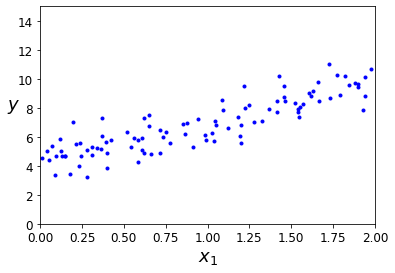

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple:

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

It's easy to visualize the fitted line: just predict two x values

In [6]:
X_new = np.array([[0], [2]])
y_predict = lin_reg.predict(X_new)

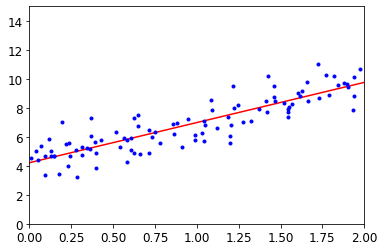

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares", which refers to MSE). 

## Computational Complexity

The approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. **If you double the number of features, you multiply the computation time by roughly 4**. It gets very slow when the number of features grows large (e.g., 100,000). On the positive side, **it is linear with regard to the number of instances** in the training set ($O(m)$), so it handles large training sets efficiently, provided they can fit in memory.

Also, **once you have trained your Linear Regression model, predictions are very fast: the computational complexity is linear with regard to both the number of
instances you want to make predictions on and the number of features**. In other words, making predictions on twice as many instances (or twice as
many features) will take roughly twice as much time. 

Now we will look at a very different way to train a Linear Regression model, which is better suited for cases where there are a large number of features or
too many training instances to fit in memory.

# Gradient Descent
_Gradient Descent_ is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient
Descent is to tweak parameters iteratively in order to minimize a cost function.

Concretely, you start by filling $\mathbf{θ}$ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum. The learning step size is proportional to
the slope of the cost function, so the steps gradually get smaller as the parameters approach the
minimum

![](img/gradient_descent.png)

An important parameter in Gradient Descent is the size of the steps, determined by the _learning rate_ hyperparameter:  
- If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
- If the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before.


## Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter $θ_j$. 
- In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit.
- This is called a _partial derivative_. It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the
same question facing north (and so on for all other dimensions). 

Notice that this approach involves calculations over the full training set X, at each Gradient Descent step! This is why the algorithm is called Batch Gradient Descent: 
- It uses the whole batch of training data at every step. 
- As a result it is terribly slow on very large training sets.


## Stochastic Gradient Descent

To overcome the problem of training the whole batch at every step, _Stochastic Gradient Descent_ picks a random instance in the training set at every step
and computes the gradients based only on that single instance.

- This makes the algorithm much faster because it has very little data to manipulate at every iteration.
- It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration. 
- On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently
decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average:

![](img/sgd.png)

In practice, with stochastic gradient descent we go through a number of rounds (called _epochs_). 
- In each epoch we iterate through $m$ (= number of instances in the training set) randomly selected instances. 
- At each such an iteration we calculate the gradient and try to approach the minimum a bit closer. 

**The number of epochs is an important hyperparameter for algorithms that use stochastic gradient descent.**

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared
error cost function. The following code runs for maximum 1,000 epochs or until the loss drops by less than 0.001 during one epoch (`max_iter=1000,
tol=1e-3`). It starts with a learning rate of 0.1 (`eta0=0.1`). Lastly, it does not use
any regularization (penalty=None; more details on this shortly):

In [8]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())  # sgd_reg.fit expects a 1d array as its 2nd parameter iso of a column vector, hence y.ravel()

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [9]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

This is very close to the result of the linear regression above. 

# 2. Polynomial Regression

What if your data is more complex than a straight line? 
- you can use a linear model to fit nonlinear data
- add powers of each feature as new features
- then train a linear model on this extended set of features. 
This technique is called _Polynomial Regression_.

In [10]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [11]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

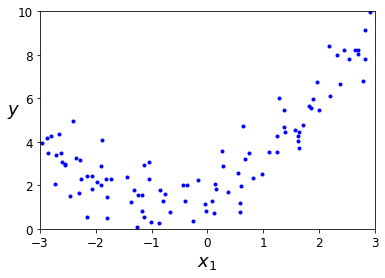

In [12]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [14]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature. Now you can fit a `LinearRegression` model to this extended training data:

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

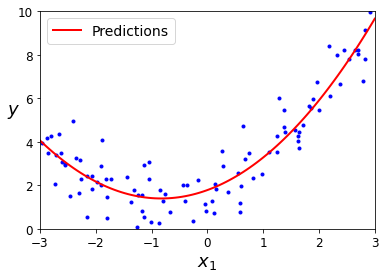

In [16]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Not bad: the model estimates $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$ when in fact the original function was $y = 0.5x_1^2 + 1.0x_1 + 2.0$ + Gaussian noise. 

Note that when there are multiple features (e.g. $x_1$ and $x_2$), Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that `PolynomialFeatures` also adds all combinations of features up to the given
degree. For example, if there were two features $a$ and $b$, `PolynomialFeatures` with degree=3 would not only add the features $a^2$, $a^3$, $b^2$ and $b^3$, but also the combinations $ab$, $a^2 b$, and $ab^2$.

High-degree Polynomial Regression can fit the training data much better than plain Linear Regression.

In the figure below we fit a 300-degree polynomial, a quadratic model (second degree) and a pure linear model (first degree) through the training set. 

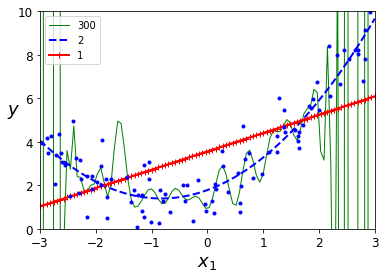

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

- The high-degree Polynomial Regression model is severely overfitting the training data.
- The linear model is underfitting it.

# 3. Regularized Linear Models

- A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. 
- A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.
- For a linear model, regularization is typically achieved by constraining the weights of the model.

## Ridge Regression

Ridge Regression is a regularized version of Linear Regression: a regularization term is added to the cost function.

$$
J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2
$$

The hyperparameter *α* controls how much you want to regularize the model/
- If *α = 0*, then Ridge Regression is just Linear Regression. 
- If *α* is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

Note that the bias term $θ_0$ is not regularized (the sum starts at *i = 1*, not *0*).

**WARNING**  
It is important to scale the data (e.g., using a StandardScaler) before performing
Ridge Regression, as it is sensitive to the scale of the input features. This is true for most regularized models.

The figures below show several Ridge models trained on some linear data using different $α$ values.

In [19]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [20]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [21]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

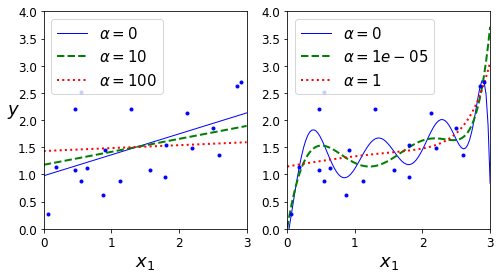

In [24]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

Note how increasing $α$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing overfitting. 

# Logistic Regression

 - Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). 
 - If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). 
 - This makes it a binary _classifier_ (although it is a regression algorithm).

 ## Estimating probabilities

 Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result.

 $$
 \hat{p} = h_{\theta}(x) = \sigma(\mathbf{x^T}\mathbf{\theta})
 $$

 The logistic—noted $σ(·)$— is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1. It is defined as:

$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

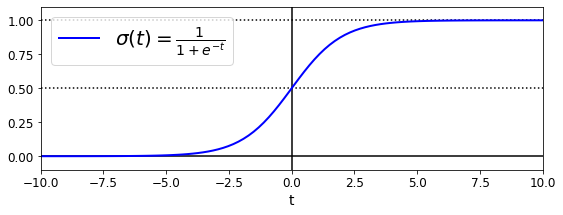

In [27]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Once the Logistic Regression model has estimated the probability $\hat{p} = h_{\theta}(x)$ that an instance $\mathbf{x}$ belongs to the positive class, it can make its prediction $ŷ$
easily:

$\hat{y} = 0$  if  $\hat{p} < 0.5$   

$\hat{y} = 1$  if  $\hat{p} \ge 0.5$


The way a logistic regression model is trained is outside the scope of this course but again it comes down to searching the minimum of a cost function. 

## Decision Boundaries
Let’s use the iris dataset to illustrate Logistic Regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers
of three different species: Iris setosa, Iris versicolor, and Iris virginica.  
 
![](img/iris.png)

Let’s try to build a classifier to detect the Iris virginica type based only on the petal width feature. First let’s load the data:

In [31]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [32]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [34]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

<ipython-input-34-c3494bf9af66>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0


Now let’s train a Logistic Regression model.   

**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [35]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

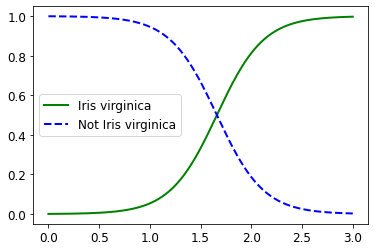

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend(loc="center left", fontsize=12)

In [40]:
y_proba

array([[9.99250016e-01, 7.49984089e-04],
       [9.99240201e-01, 7.59799387e-04],
       [9.99230257e-01, 7.69743043e-04],
       ...,
       [3.08374822e-03, 9.96916252e-01],
       [3.04400296e-03, 9.96955997e-01],
       [3.00476842e-03, 9.96995232e-01]])

The figure in the book actually is actually a bit fancier:

C:\Users\jcor864\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


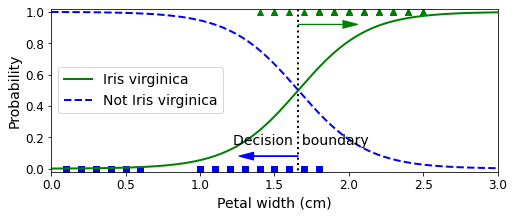

In [42]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [60]:
decision_boundary

array([1.66066066])

The petal width of Iris virginica flowers (represented by triangles) ranges
from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares)
generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice
that there is a bit of overlap. Above about 2 cm the classifier is highly
confident that the flower is an Iris virginica (it outputs a high probability for
that class), while below 1 cm it is highly confident that it is not an Iris
virginica (high probability for the “Not Iris virginica” class). In between
these extremes, the classifier is unsure. However, if you ask it to predict the
class (using the predict() method rather than the predict_proba()
method), it will return whichever class is the most likely. Therefore, there is
a decision boundary at around 1.6 cm where both probabilities are equal to
50%: if the petal width is higher than 1.6 cm, the classifier will predict that
the flower is an Iris virginica, and otherwise it will predict that it is not
(even if it is not very confident):

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## Softmax Regression

Saving figure logistic_regression_contour_plot


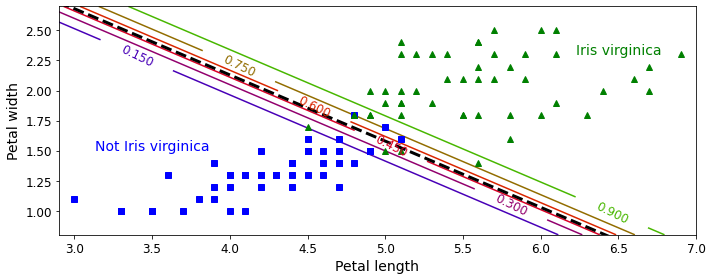

In [62]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [63]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


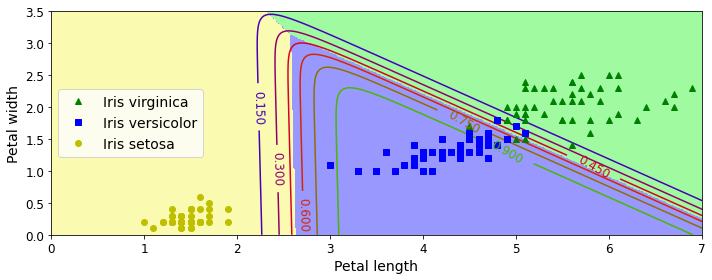

In [64]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [65]:
softmax_reg.predict([[5, 2]])

array([2])

In [66]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])